# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.6.0-delta.new.72.fix.120.155.157'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Peru Data Repository (2019), https://github.com/
COVID-19 Peru Data Repository (2020), https://github.com/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
168780,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168781,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168782,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168783,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168784,2020-08-02,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
168780,2020-07-29,Colombia,Vichada,2,1,0,1
168781,2020-07-30,Colombia,Vichada,2,1,0,1
168782,2020-07-31,Colombia,Vichada,2,1,0,1
168783,2020-08-01,Colombia,Vichada,2,1,0,1
168784,2020-08-02,Colombia,Vichada,2,1,0,1


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
196,2020-07-29,11861,2774,329,8758
197,2020-07-30,12228,2789,330,9109
198,2020-07-31,12691,2921,332,9438
199,2020-08-01,13163,3216,332,9615
200,2020-08-02,13455,3508,332,9615


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-29,17019873,6467891,668343,9883639,0.019634,0.290356,0.063338
2020-07-30,17327291,6583255,674311,10069725,0.019458,0.290574,0.062761
2020-07-31,17578906,6640183,680456,10258267,0.019354,0.291778,0.062206
2020-08-01,17849546,6687397,685538,10476611,0.019203,0.293470,0.061416
2020-08-02,17851703,6688843,685551,10477309,0.019201,0.293454,0.061414


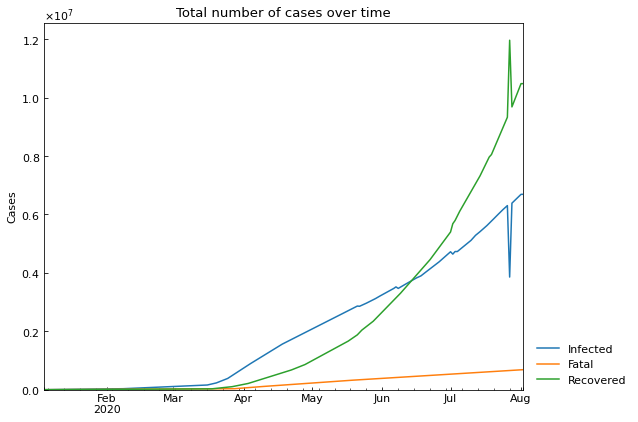

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
207,2020-07-29,33448,8942,1005,23501
208,2020-07-30,34749,9569,1006,24174
209,2020-07-31,36330,10395,1012,24923
210,2020-08-01,37866,11357,1012,25497
211,2020-08-02,39197,12285,1012,25900


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
168780,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168781,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168782,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168783,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168784,2020-08-02,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
165564,COL,Colombia,Vichada,2020-07-29,107808
165565,COL,Colombia,Vichada,2020-07-30,107808
165566,COL,Colombia,Vichada,2020-07-31,107808
165567,COL,Colombia,Vichada,2020-08-01,107808
165568,COL,Colombia,Vichada,2020-08-02,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
168780,2020-07-29,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168781,2020-07-30,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168782,2020-07-31,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168783,2020-08-01,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04
168784,2020-08-02,2,1,0,107808.0,COL,Vichada,Colombia,3,3,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
168780,2020-07-29,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
168781,2020-07-30,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
168782,2020-07-31,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
168783,2020-08-01,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04
168784,2020-08-02,Colombia,COL,3,3,2,4,1,2,2,4,2,2,2,87.04


In [23]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
207,2020-07-29,1,1,1,0,0,1,1,3,2,2,1,32.41
208,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
209,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
210,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41
211,2020-08-02,1,1,1,0,0,1,1,3,2,2,1,32.41


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
207,2020-07-29,1,1,1,0,0,1,1,3,2,2,1,32.41
208,2020-07-30,1,1,1,0,0,1,1,3,2,2,1,32.41
209,2020-07-31,1,1,1,0,0,1,1,3,2,2,1,32.41
210,2020-08-01,1,1,1,0,0,1,1,3,2,2,1,32.41
211,2020-08-02,1,1,1,0,0,1,1,3,2,2,1,32.41


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

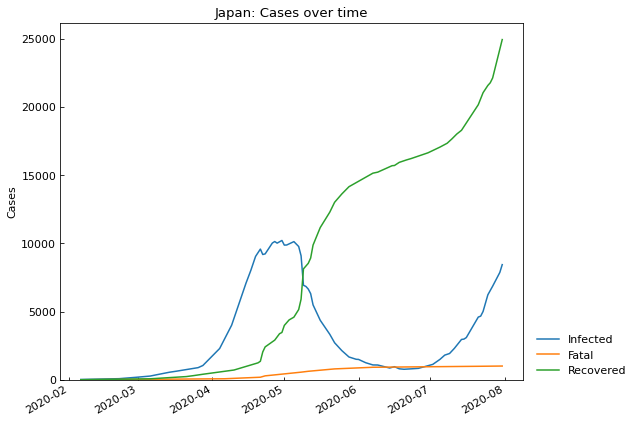

,Date,Confirmed,Infected,Fatal,Recovered
167,2020-07-27,29969,6857,996,22116
168,2020-07-28,30961,7152,998,22811
169,2020-07-29,31901,7393,1001,23507
170,2020-07-30,33049,7866,1004,24179
171,2020-07-31,34372,8437,1006,24929


In [26]:
import matplotlib
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

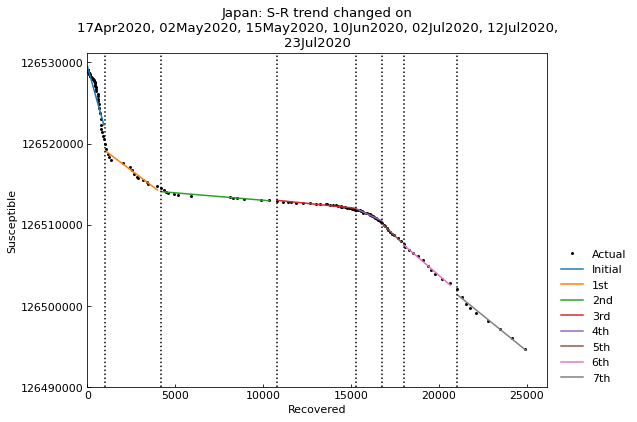

,Type,Start,End,Population
1st,Past,17Apr2020,01May2020,126529100
2nd,Past,02May2020,14May2020,126529100
3rd,Past,15May2020,09Jun2020,126529100
4th,Past,10Jun2020,01Jul2020,126529100
5th,Past,02Jul2020,11Jul2020,126529100
6th,Past,12Jul2020,22Jul2020,126529100
7th,Past,23Jul2020,31Jul2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>

Running optimization with 4 CPUs...

	7th phase with SIR-F model finished 894 trials in 0 min 25 sec.

	3rd phase with SIR-F model finished 1050 trials in 0 min 30 sec.

	5th phase with SIR-F model finished 214 trials in 0 min 5 sec.

	6th phase with SIR-F model finished 402 trials in 0 min 10 sec.

	1st phase with SIR-F model finished 1826 trials in 1 min 0 sec.

	2nd phase with SIR-F model finished 1816 trials in 1 min 0 sec.

	4th phase with SIR-F model finished 1812 trials in 1 min 0 sec.

Completed optimization. Total: 1 min 26 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,17Apr2020,01May2020,126529100,SIR-F,0.014252,0.007315,0.031357,0.000315,480,1.81,0.031,1058,23,45,0.133061,1826,1 min 0 sec
2nd,Past,02May2020,14May2020,126529100,SIR-F,0.004459,0.021422,0.178219,0.000050,480,0.17,0.178,6691,74,15,0.168213,1816,1 min 0 sec
3rd,Past,15May2020,09Jun2020,126529100,SIR-F,0.006498,0.027213,0.190203,0.000021,480,0.19,0.190,15574,51,12,0.118289,1050,0 min 30 sec
4th,Past,10Jun2020,01Jul2020,126529100,SIR-F,0.021487,0.023700,0.030952,0.000349,480,0.87,0.031,956,15,14,0.141763,1812,1 min 0 sec
5th,Past,02Jul2020,11Jul2020,126529100,SIR-F,0.048835,0.022306,0.000680,0.000079,480,2.18,0.001,4208,6,14,0.027441,214,0 min 5 sec
6th,Past,12Jul2020,22Jul2020,126529100,SIR-F,0.043975,0.022673,0.000418,0.000081,480,1.93,0.000,4125,7,14,0.023164,402,0 min 10 sec
7th,Past,23Jul2020,31Jul2020,126529100,SIR-F,0.046273,0.024516,0.000068,0.000078,480,1.88,0.000,4249,7,13,0.033589,894,0 min 25 sec


### Accuracy of estimation

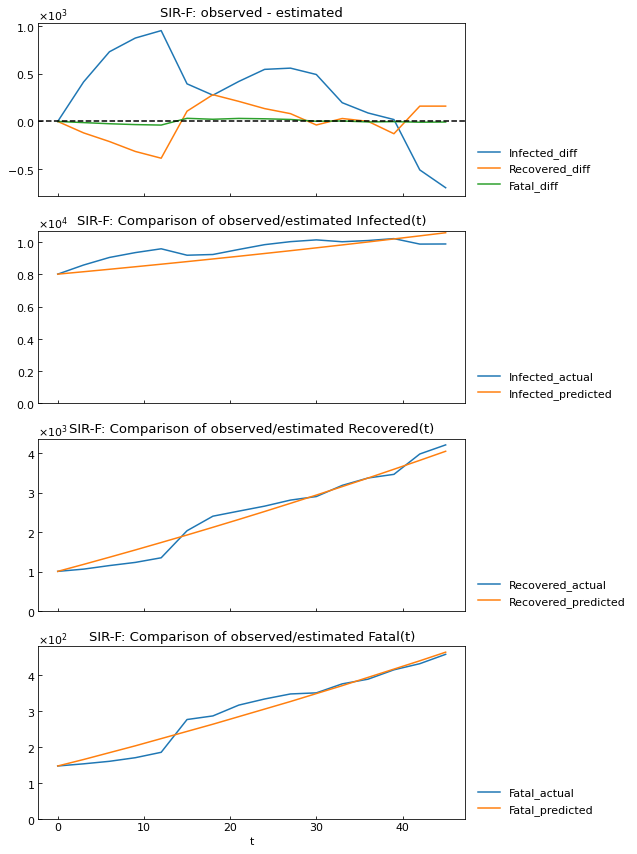

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

0.87

### Show parameter history

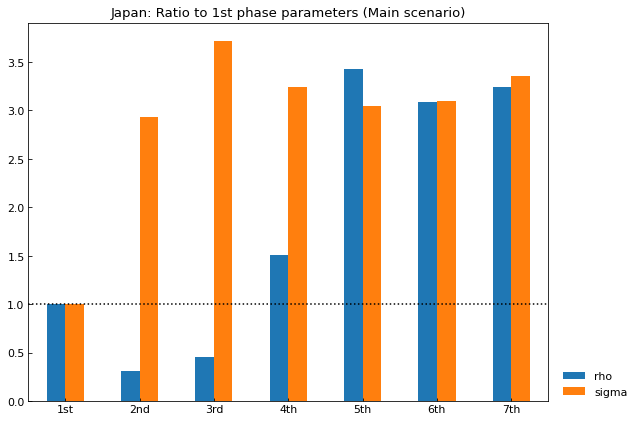

,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.312862,0.455932,1.507699,3.426669,3.085641,3.246881
sigma,1.0,2.928666,3.720356,3.240054,3.049454,3.099673,3.351638


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

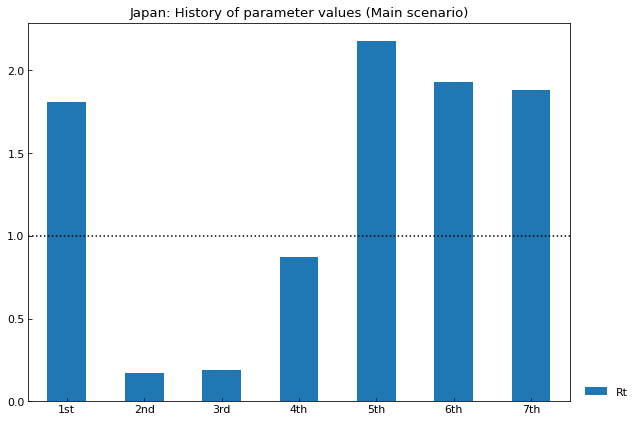

,1st,2nd,3rd,4th,5th,6th,7th
Rt,1.81,0.17,0.19,0.87,2.18,1.93,1.88


In [33]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

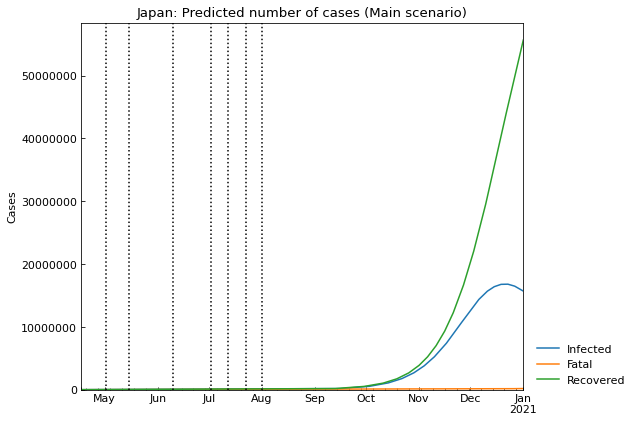

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,169847,16349502,51342210,58667540
256,29Dec2020,173744,16197603,52537712,57620040
257,30Dec2020,177602,16026112,53721836,56603548
258,31Dec2020,181418,15835583,54893149,55618949
259,01Jan2021,183937,15698992,55666762,54979409


In [34]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [35]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.024515901161443848

In [36]:
sigma_new = sigma_current * 2
sigma_new

0.049031802322887695

In [37]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE       rho  \
Scenario Phase                                                              
Main     0th      Past  17Apr2020  01May2020   126529100  SIR-F  0.014252   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.004459   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.006498   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.021487   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  0.048835   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  0.043975   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  0.046273   
         7th    Future  01Aug2020  01Jan2021   126529100  SIR-F  0.046273   
Medicine 0th      Past  17Apr2020  01May2020   126529100  SIR-F  0.014252   
         1st      Past  02May2020  14May2020   126529100  SIR-F  0.004459   
         2nd      Past  15May2020  09Jun2020   126529100  SIR-F  0.006498   
         3rd      Past  10Jun2020  01Jul2020   126529100  SIR-F  0.021487   
         4th      Past  02Jul2020  11Jul2020   126529100  SIR-F  0.048835   
         5th      Past  12Jul2020  22Jul2020   126529100  SIR-F  0.043975   
         6th      Past  23Jul2020  31Jul2020   126529100  SIR-F  0.046273   
         7th    Future  01Aug2020  31Aug2020   126529100  SIR-F  0.046273   
         8th    Future  01Sep2020  01Jan2021   126529100  SIR-F  0.046273   

                   sigma     theta     kappa  tau    Rt  alpha1 [-]  \
Scenario Phase                                                        
Main     0th    0.007315  0.031357  0.000315  480  1.81       0.031   
         1st    0.021422  0.178219  0.000050  480  0.17       0.178   
         2nd    0.027213  0.190203  0.000021  480  0.19       0.190   
         3rd    0.023700  0.030952  0.000349  480  0.87       0.031   
         4th    0.022306  0.000680  0.000079  480  2.18       0.001   
         5th    0.022673  0.000418  0.000081  480  1.93       0.000   
         6th    0.024516  0.000068  0.000078  480  1.88       0.000   
         7th    0.024516  0.000068  0.000078  480  1.88       0.000   
Medicine 0th    0.007315  0.031357  0.000315  480  1.81       0.031   
         1st    0.021422  0.178219  0.000050  480  0.17       0.178   
         2nd    0.027213  0.190203  0.000021  480  0.19       0.190   
         3rd    0.023700  0.030952  0.000349  480  0.87       0.031   
         4th    0.022306  0.000680  0.000079  480  2.18       0.001   
         5th    0.022673  0.000418  0.000081  480  1.93       0.000   
         6th    0.024516  0.000068  0.000078  480  1.88       0.000   
         7th    0.024516  0.000068  0.000078  480  1.88       0.000   
         8th    0.049032  0.000068  0.000078  480  0.94       0.000   

                1/alpha2 [day]  1/beta [day]  1/gamma [day]      RMSLE Trials  \
Scenario Phase                                                                  
Main     0th              1058            23             45   0.133061   1826   
         1st              6691            74             15   0.168213   1816   
         2nd             15574            51             12   0.118289   1050   
         3rd               956            15             14   0.141763   1812   
         4th              4208             6             14  0.0274405    214   
         5th              4125             7             14  0.0231644    402   
         6th              4249             7             13  0.0335894    894   
         7th              4249             7             13          -      -   
Medicine 0th              1058            23             45   0.133061   1826   
         1st              6691            74             15   0.168213   1816   
         2nd             15574            51             12   0.118289   1050   
         3rd               956            15             14   0.141763   1812   
         4th              4208             6             14  0.0274405

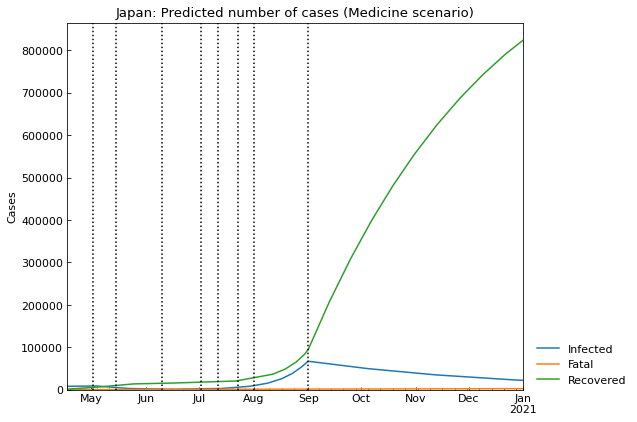

,Date,Fatal,Infected,Recovered,Susceptible
255,28Dec2020,2424,22817,812201,125691657
256,29Dec2020,2430,22603,815542,125688525
257,30Dec2020,2435,22390,818851,125685423
258,31Dec2020,2441,22180,822129,125682350
259,01Jan2021,2444,22040,824298,125680317


In [38]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [39]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 01Jan2021,Fatal on 01Jan2021
Main,16830347,21Dec2020,15698992,183937
Medicine,67053,01Sep2020,22040,2444
